In [1]:
# =============================================================
# DCIT 411: Bioinformatics — Sequence Alignment with Biopython
# Student  : Amoako Albert | 11227686
# Module   : msa.py
# Purpose  : Multiple Sequence Alignment using ClustalW, MAFFT,
#            and MUSCLE via Biopython wrappers. Loads cleaned 
#            data from config, saves results to configured dirs.
# =============================================================


In [2]:

import os
import sys
import time
import tracemalloc
import logging
import subprocess
from pathlib import Path
from collections import Counter
from itertools import combinations

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from Bio import AlignIO, SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

#  ── Import config for directory paths ─────────────────────────
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
sys.path.append(os.path.abspath(".."))
import config

# ── Logging setup (falls back to print if needed) ─────────────
try:
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s [%(levelname)s] %(message)s",
        datefmt="%H:%M:%S",
        handlers=[
            logging.FileHandler(os.path.join(config.RESULTS_DIR, "msa.log")),
            logging.StreamHandler()
        ]
    )
    log = logging.getLogger(__name__)
except Exception:
    log = None

def _log(msg, level="info"):
    """Internal logger wrapper that falls back to print."""
    if log and hasattr(log, level):
        getattr(log, level)(msg)
    else:
        print(f"[{level.upper()}] {msg}")


Configuration loaded and directory structure verified.


In [3]:


# =============================================================
# SECTION 1: Input Preparation (Config-Integrated)
# =============================================================

def write_multifasta(records: list[SeqRecord], filename: str = None,
                     directory: str = None) -> str:
    """
    Write a list of SeqRecords to a multi-FASTA file in configured directory.
    
    Parameters
    ----------
    records   : List of SeqRecord objects
    filename  : Output filename (default: auto-generated timestamp)
    directory : Override directory (default: config.PROCESSED_DATA_DIR)
    
    Returns
    -------
    str : Absolute path to the written file
    """
    dir_path = directory or config.PROCESSED_DATA_DIR
    Path(dir_path).mkdir(parents=True, exist_ok=True)
    
    if filename is None:
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        filename = f"msa_input_{timestamp}.fasta"
    
    output_path = os.path.join(dir_path, filename)
    count = SeqIO.write(records, output_path, "fasta")
    _log(f"Written {count} sequences → {output_path}")
    return str(Path(output_path).resolve())


def load_sequences_for_msa(
    filename: str = None,
    directory: str = None,
    fmt: str = "fasta",
    min_seqs: int = 3,
    min_length: int = 10
) -> list[SeqRecord]:
    """
    Load and validate sequences from configured processed directory for MSA.
    
    Parameters
    ----------
    filename   : Name of FASTA file in PROCESSED_DATA_DIR
    directory  : Override directory (default: config.PROCESSED_DATA_DIR)
    fmt        : File format (default: 'fasta')
    min_seqs   : Minimum sequences required (default: 3)
    min_length : Minimum sequence length (default: 10)
    
    Returns
    -------
    list[SeqRecord] : Validated sequence records ready for MSA
    """
    dir_path = directory or config.PROCESSED_DATA_DIR
    
    if filename:
        file_path = os.path.join(dir_path, filename)
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
        records = list(SeqIO.parse(file_path, fmt))
        _log(f"Loaded {len(records)} sequence(s) from: {filename}")
    else:
        # Load all FASTA files in directory
        records = []
        for f in Path(dir_path).glob("*.fasta"):
            records.extend(SeqIO.parse(f, fmt))
        _log(f"Loaded {len(records)} sequence(s) from: {dir_path}")
    
    # Validation
    if len(records) < min_seqs:
        raise ValueError(f"MSA requires at least {min_seqs} sequences. Got {len(records)}.")
    
    ids = [r.id for r in records]
    if len(ids) != len(set(ids)):
        dupes = [i for i in ids if ids.count(i) > 1]
        raise ValueError(f"Duplicate sequence IDs found: {set(dupes)}")
    
    for r in records:
        if len(r.seq) < min_length:
            raise ValueError(f"Sequence '{r.id}' is too short ({len(r.seq)} residues). Minimum is {min_length}.")
    
    _log(f"Validation passed: {len(records)} sequences ready for MSA.")
    for r in records:
        _log(f"  → {r.id:<30} length={len(r.seq):>6}")
    return records




In [4]:
# =============================================================
# SECTION 2: Tool Availability Check
# =============================================================

def check_tool(tool_name: str) -> bool:
    """Check if an external alignment tool is installed on system PATH."""
    try:
        result = subprocess.run(
            [tool_name, "--help"],
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL,
            timeout=5
        )
        _log(f"Tool '{tool_name}' is available ✓")
        return True
    except (FileNotFoundError, subprocess.TimeoutExpired):
        _log(f"Tool '{tool_name}' NOT found on PATH.", "warning")
        return False


def check_all_tools() -> dict:
    """Check availability of all MSA tools used in this project."""
    tools = {
        "clustalw2": "sudo apt-get install clustalw",
        "mafft": "sudo apt-get install mafft",
        "muscle": "sudo apt-get install muscle",
        "hmmbuild": "sudo apt-get install hmmer",
        "hmmsearch": "sudo apt-get install hmmer",
    }
    status = {}
    print("\n  Tool Availability Check")
    print("  " + "─" * 50)
    for tool, install_cmd in tools.items():
        available = check_tool(tool)
        status[tool] = available
        icon = "✓" if available else "✗"
        hint = "" if available else f"  → Install: {install_cmd}"
        print(f"  [{icon}] {tool:<15}{hint}")
    print()
    return status




In [5]:
# =============================================================
# SECTION 3: MSA Runners (Config-Integrated Output)
# =============================================================

def _measure(fn, *args, **kwargs):
    """Helper: run function while measuring time and memory usage."""
    tracemalloc.start()
    t0 = time.perf_counter()
    result = fn(*args, **kwargs)
    elapsed = time.perf_counter() - t0
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    peak_mb = peak / 1024 / 1024
    return result, elapsed, peak_mb


def run_clustalw(input_fasta: str, output_aln: str = None,
                 output_tree: str = None, directory: str = None) -> MultipleSeqAlignment:
    """Run ClustalW progressive MSA via Biopython's command-line wrapper."""
    if not check_tool("clustalw2"):
        raise RuntimeError("ClustalW not found. Install with: sudo apt-get install clustalw")
    
    dir_path = directory or config.ALIGNMENTS_DIR
    Path(dir_path).mkdir(parents=True, exist_ok=True)
    
    base = Path(input_fasta).stem
    output_aln = output_aln or os.path.join(dir_path, f"{base}_clustalw.aln")
    output_tree = output_tree or os.path.join(dir_path, f"{base}_clustalw.dnd")
    
    from Bio.Align.Applications import ClustalwCommandline
    cline = ClustalwCommandline(
        "clustalw2", infile=input_fasta, outfile=output_aln,
        newtree=output_tree, outorder="aligned",
    )
    
    _log(f"Running ClustalW: {cline}")
    stdout, stderr = cline()
    
    alignment = AlignIO.read(output_aln, "clustal")
    _log(f"ClustalW complete: {len(alignment)} seqs, {alignment.get_alignment_length()} columns")
    return alignment


def run_mafft(input_fasta: str, output_aln: str = None,
              strategy: str = "auto", directory: str = None) -> MultipleSeqAlignment:
    """Run MAFFT MSA via subprocess with configurable strategy."""
    if not check_tool("mafft"):
        raise RuntimeError("MAFFT not found. Install with: sudo apt-get install mafft")
    
    dir_path = directory or config.ALIGNMENTS_DIR
    Path(dir_path).mkdir(parents=True, exist_ok=True)
    
    base = Path(input_fasta).stem
    output_aln = output_aln or os.path.join(dir_path, f"{base}_mafft.fasta")
    
    strategy_flags = {
        "auto": ["--auto"],
        "linsi": ["--localpair", "--maxiterate", "1000"],
        "ginsi": ["--globalpair", "--maxiterate", "1000"],
        "einsi": ["--ep", "0", "--genafpair", "--maxiterate", "1000"],
        "fftns1": ["--retree", "1", "--maxiterate", "0"],
        "fftns2": ["--retree", "2", "--maxiterate", "0"],
    }
    flags = strategy_flags.get(strategy, ["--auto"])
    
    cmd = ["mafft"] + flags + ["--out", output_aln, input_fasta]
    _log(f"Running MAFFT: {' '.join(cmd)}")
    
    result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if result.returncode != 0:
        raise RuntimeError(f"MAFFT failed:\n{result.stderr}")
    
    alignment = AlignIO.read(output_aln, "fasta")
    _log(f"MAFFT complete: {len(alignment)} seqs, {alignment.get_alignment_length()} columns")
    return alignment


def run_muscle(input_fasta: str, output_aln: str = None,
               max_iters: int = 16, directory: str = None) -> MultipleSeqAlignment:
    """Run MUSCLE MSA via subprocess with configurable iterations."""
    if not check_tool("muscle"):
        raise RuntimeError("MUSCLE not found. Install with: sudo apt-get install muscle")
    
    dir_path = directory or config.ALIGNMENTS_DIR
    Path(dir_path).mkdir(parents=True, exist_ok=True)
    
    base = Path(input_fasta).stem
    output_aln = output_aln or os.path.join(dir_path, f"{base}_muscle.fasta")
    
    cmd = ["muscle", "-in", input_fasta, "-out", output_aln, "-maxiters", str(max_iters)]
    _log(f"Running MUSCLE: {' '.join(cmd)}")
    
    result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if result.returncode != 0:
        raise RuntimeError(f"MUSCLE failed:\n{result.stderr}")
    
    alignment = AlignIO.read(output_aln, "fasta")
    _log(f"MUSCLE complete: {len(alignment)} seqs, {alignment.get_alignment_length()} columns")
    return alignment




In [6]:
# =============================================================
# SECTION 4: Benchmarking (Config-Integrated)
# =============================================================

def benchmark_all(records: list[SeqRecord], input_filename: str = None,
                  directory: str = None) -> list[dict]:
    """Run all three MSA tools and record performance metrics."""
    input_path = write_multifasta(records, filename=input_filename, directory=directory)
    
    runners = {
        "ClustalW": lambda: run_clustalw(input_path, directory=directory),
        "MAFFT": lambda: run_mafft(input_path, directory=directory),
        "MUSCLE": lambda: run_muscle(input_path, directory=directory),
    }
    
    results = []
    print("\n  " + "═" * 65)
    print("  MSA Benchmark — Three Tools on Same Input")
    print("  " + "═" * 65)
    print(f"  {'Tool':<12} {'Time (s)':>10} {'Mem (MB)':>10} {'Cols':>8} {'Conserved':>12} {'AvgID%':>8}")
    print("  " + "─" * 65)
    
    for tool_name, runner in runners.items():
        try:
            aln, elapsed, peak_mb = _measure(runner)
            stats = alignment_statistics(aln)
            
            row = {
                "tool": tool_name, "time_sec": round(elapsed, 4),
                "memory_mb": round(peak_mb, 3), "aln_length": stats["aln_length"],
                "conserved_cols": stats["conserved_cols"],
                "avg_identity": stats["avg_identity"], "alignment": aln,
            }
            results.append(row)
            print(f"  {tool_name:<12} {elapsed:>10.4f} {peak_mb:>10.3f} "
                  f"{stats['aln_length']:>8} {stats['conserved_cols']:>12} "
                  f"{stats['avg_identity']:>7.1f}%")
        except RuntimeError as e:
            _log(f"{tool_name} FAILED: {e}", "error")
            results.append({"tool": tool_name, "error": str(e)})
    
    print("  " + "═" * 65 + "\n")
    return results




In [7]:
# =============================================================
# SECTION 5: MSA Statistics
# =============================================================

def alignment_statistics(alignment: MultipleSeqAlignment) -> dict:
    """Compute summary statistics for a multiple sequence alignment."""
    n_seqs = len(alignment)
    aln_len = alignment.get_alignment_length()
    conserved, variable, gap_only = 0, 0, 0
    conservation = []
    
    for i in range(aln_len):
        col = alignment[:, i]
        counts = Counter(col)
        n_gap = counts.get("-", 0)
        
        if n_gap == n_seqs:
            gap_only += 1
            conservation.append(0.0)
            continue
        
        non_gap_counts = {k: v for k, v in counts.items() if k != "-"}
        most_common_freq = max(non_gap_counts.values())
        total_non_gap = sum(non_gap_counts.values())
        cons_score = most_common_freq / total_non_gap
        conservation.append(cons_score)
        
        if len(non_gap_counts) == 1:
            conserved += 1
        else:
            variable += 1
    
    # Average pairwise identity
    identities = []
    for i, j in combinations(range(n_seqs), 2):
        s1, s2 = str(alignment[i].seq), str(alignment[j].seq)
        matches = sum(a == b and a != "-" for a, b in zip(s1, s2))
        length = sum(1 for a, b in zip(s1, s2) if a != "-" or b != "-")
        if length > 0:
            identities.append(matches / length * 100)
    
    avg_id = round(sum(identities) / len(identities), 2) if identities else 0.0
    
    return {
        "aln_length": aln_len, "n_seqs": n_seqs,
        "conserved_cols": conserved, "variable_cols": variable,
        "gap_only_cols": gap_only, "avg_identity": avg_id,
        "conservation": conservation,
    }


def print_msa_summary(alignment: MultipleSeqAlignment, label: str = "") -> None:
    """Print a formatted summary of an MSA."""
    stats = alignment_statistics(alignment)
    print(f"\n  MSA Summary{' — ' + label if label else ''}")
    print(f"  {'─' * 45}")
    print(f"  {'Sequences':<28}: {stats['n_seqs']}")
    print(f"  {'Alignment Length':<28}: {stats['aln_length']} columns")
    print(f"  {'Conserved Columns':<28}: {stats['conserved_cols']}")
    print(f"  {'Variable Columns':<28}: {stats['variable_cols']}")
    print(f"  {'Gap-Only Columns':<28}: {stats['gap_only_cols']}")
    print(f"  {'Avg Pairwise Identity':<28}: {stats['avg_identity']:.2f}%")
    print(f"  {'─' * 45}\n")


def print_alignment_block(alignment: MultipleSeqAlignment, start: int = 0,
                          end: int = 60, label: str = "") -> None:
    """Print a formatted block of the MSA with conservation indicators."""
    end = min(end, alignment.get_alignment_length())
    print(f"\n  {'═' * 75}")
    if label:
        print(f"  {label}")
        print(f"  {'─' * 75}")
    
    id_width = min(20, max(len(r.id) for r in alignment) + 2)
    
    for record in alignment:
        short_id = record.id[:id_width - 1]
        seq_slice = str(record.seq[start:end])
        print(f"  {short_id:<{id_width}} {seq_slice}")
    
    # Conservation line
    cons_line = []
    for i in range(start, end):
        col = alignment[:, i]
        counts = Counter(col)
        total = len(col)
        n_gap = counts.get("-", 0)
        non_gap = {k: v for k, v in counts.items() if k != "-"}
        
        if not non_gap:
            cons_line.append(" ")
        elif len(non_gap) == 1 and n_gap == 0:
            cons_line.append("*")
        elif max(non_gap.values()) / total >= 0.7:
            cons_line.append(":")
        elif max(non_gap.values()) / total >= 0.4:
            cons_line.append(".")
        else:
            cons_line.append(" ")
    
    print(f"  {'Conservation':<{id_width}} {''.join(cons_line)}")
    print(f"  {'═' * 75}\n")
    print(f"  Positions {start + 1}–{end}  |  * conserved  : strong  . weak")




In [8]:
# =============================================================
# SECTION 6: Consensus Sequence
# =============================================================

def generate_consensus(alignment: MultipleSeqAlignment, threshold: float = 0.7,
                       gap_cutoff: float = 0.5) -> SeqRecord:
    """Generate a consensus sequence from an MSA."""
    n_seqs = len(alignment)
    aln_len = alignment.get_alignment_length()
    consensus, skipped, ambiguous = [], 0, 0
    
    for i in range(aln_len):
        col = alignment[:, i]
        counts = Counter(col)
        n_gap = counts.get("-", 0)
        
        if n_gap / n_seqs > gap_cutoff:
            skipped += 1
            continue
        
        non_gap = {k: v for k, v in counts.items() if k != "-"}
        if not non_gap:
            skipped += 1
            continue
        
        total_non_gap = sum(non_gap.values())
        most_common, freq = max(non_gap.items(), key=lambda x: x[1])
        
        if freq / total_non_gap >= threshold:
            consensus.append(most_common)
        else:
            consensus.append("X")
            ambiguous += 1
    
    consensus_str = "".join(consensus)
    _log(f"Consensus generated: {len(consensus_str)} residues "
         f"(threshold={threshold*100:.0f}%, skipped={skipped} cols, ambiguous={ambiguous})")
    
    return SeqRecord(
        Seq(consensus_str), id=f"consensus_{int(threshold*100)}pct",
        description=f"Consensus from {n_seqs} sequences | threshold={threshold} | length={len(consensus_str)}",
    )


def compare_consensus_thresholds(alignment: MultipleSeqAlignment,
                                  thresholds: list = None) -> list:
    """Generate and compare consensus sequences at multiple thresholds."""
    if thresholds is None:
        thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    
    print(f"\n  Consensus Comparison Across Thresholds")
    print(f"  {'─' * 60}")
    print(f"  {'Threshold':>10} {'Length':>8} {'First 40 residues'}")
    print(f"  {'─' * 60}")
    
    records = []
    for t in thresholds:
        cons = generate_consensus(alignment, threshold=t)
        preview = str(cons.seq)[:40] + ("..." if len(cons.seq) > 40 else "")
        print(f"  {t*100:>9.0f}% {len(cons.seq):>8}   {preview}")
        records.append(cons)
    
    print(f"  {'─' * 60}")
    print(f"\n  Interpretation: Higher threshold → shorter, more conserved consensus")
    return records




In [9]:
# =============================================================
# SECTION 7: Visualization (Config-Integrated Saving)
# =============================================================

def save_figure(fig, filename: str, directory: str = None, dpi: int = 200) -> str:
    """Save matplotlib figure to configured figures directory."""
    dir_path = directory or config.FIGURES_DIR
    Path(dir_path).mkdir(parents=True, exist_ok=True)
    filepath = os.path.join(dir_path, filename)
    
    fig.savefig(filepath, dpi=dpi, bbox_inches="tight", facecolor=fig.get_facecolor())
    _log(f"Figure saved → {filepath}")
    return filepath


def plot_conservation_track(alignment: MultipleSeqAlignment, tool_name: str = "MSA",
                            filename: str = None, directory: str = None,
                            window: int = 5) -> str:
    """Plot per-column conservation scores and save to configured directory."""
    stats = alignment_statistics(alignment)
    cons = np.array(stats["conservation"])
    x = np.arange(len(cons))
    smooth = np.convolve(cons, np.ones(window) / window, mode="same")
    
    fig, ax = plt.subplots(figsize=(14, 4))
    fig.patch.set_facecolor("#0d1117")
    ax.set_facecolor("#0d1117")
    
    colors = ["#00c9a7" if c >= 0.9 else "#4a9eff" if c >= 0.7 
              else "#f5a623" if c >= 0.4 else "#e94560" for c in cons]
    
    ax.bar(x, cons, color=colors, width=1.0, alpha=0.75, linewidth=0)
    ax.plot(x, smooth, color="white", linewidth=1.5, alpha=0.9, label=f"Rolling avg (w={window})")
    
    ax.set_xlim(0, len(cons))
    ax.set_ylim(0, 1.05)
    ax.set_xlabel("Alignment Column", color="white", fontsize=10)
    ax.set_ylabel("Conservation Score", color="white", fontsize=10)
    ax.set_title(f"Per-Column Conservation — {tool_name} ({alignment.get_alignment_length()} cols, {len(alignment)} seqs)",
                 color="white", fontweight="bold", fontsize=12)
    ax.tick_params(colors="white")
    ax.legend(facecolor="#1a2540", labelcolor="white", fontsize=9)
    
    patches = [
        mpatches.Patch(color="#00c9a7", label="≥ 90% Conserved"),
        mpatches.Patch(color="#4a9eff", label="70–90%"),
        mpatches.Patch(color="#f5a623", label="40–70%"),
        mpatches.Patch(color="#e94560", label="< 40% (Variable)"),
    ]
    ax.legend(handles=patches, facecolor="#1a2540", labelcolor="white", fontsize=8, loc="upper right")
    
    for spine in ax.spines.values():
        spine.set_edgecolor("#2d3748")
    
    plt.tight_layout()
    if filename is None:
        filename = f"conservation_{tool_name.lower()}.png"
    save_path = save_figure(fig, filename, directory)
    plt.show()
    plt.close()
    return save_path


def plot_benchmark_comparison(benchmark_results: list[dict],
                               filename: str = "benchmark_comparison.png",
                               directory: str = None) -> str:
    """Side-by-side bar charts comparing MSA tools and save to configured directory."""
    valid = [r for r in benchmark_results if "error" not in r]
    if not valid:
        _log("No valid benchmark results to plot.", "error")
        return None
    
    tools = [r["tool"] for r in valid]
    times = [r["time_sec"] for r in valid]
    memories = [r["memory_mb"] for r in valid]
    conserved = [r["conserved_cols"] for r in valid]
    identities = [r["avg_identity"] for r in valid]
    
    x = np.arange(len(tools))
    colors = ["#4a9eff", "#2ecc71", "#f5a623"][:len(tools)]
    
    fig, axes = plt.subplots(2, 2, figsize=(13, 8))
    fig.patch.set_facecolor("#0d1117")
    fig.suptitle("MSA Tool Benchmark Comparison", color="white", fontsize=13, fontweight="bold", y=1.01)
    
    metrics = [
        (axes[0, 0], times, "Runtime (seconds)", "Time"),
        (axes[0, 1], memories, "Peak Memory (MB)", "Memory"),
        (axes[1, 0], conserved, "Conserved Columns", "Conserved"),
        (axes[1, 1], identities, "Avg Pairwise Identity (%)", "Identity"),
    ]
    
    for ax, values, ylabel, title in metrics:
        ax.set_facecolor("#0d1117")
        bars = ax.bar(x, values, color=colors, edgecolor="#2d3748", linewidth=0.8)
        ax.set_xticks(x)
        ax.set_xticklabels(tools, color="white", fontsize=10)
        ax.set_ylabel(ylabel, color="white", fontsize=9)
        ax.set_title(title, color="white", fontsize=10, fontweight="bold")
        ax.tick_params(colors="white")
        for spine in ax.spines.values():
            spine.set_edgecolor("#2d3748")
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.02,
                    f"{val:.2f}", ha="center", va="bottom", color="white", fontsize=9, fontweight="bold")
    
    plt.tight_layout()
    save_path = save_figure(fig, filename, directory)
    plt.show()
    plt.close()
    return save_path


def plot_msa_heatmap(alignment: MultipleSeqAlignment, tool_name: str = "MSA",
                     filename: str = None, directory: str = None,
                     max_cols: int = 100) -> str:
    """Visualize MSA as colored heatmap and save to configured directory."""
    n_seqs = len(alignment)
    aln_len = min(alignment.get_alignment_length(), max_cols)
    ids = [r.id[:18] for r in alignment]
    
    aa_colors = {
        "A": 0.2, "V": 0.2, "I": 0.2, "L": 0.2, "M": 0.2,
        "F": 0.3, "W": 0.3, "Y": 0.3,
        "K": 0.5, "R": 0.5, "H": 0.5,
        "D": 0.7, "E": 0.7,
        "S": 0.85, "T": 0.85, "N": 0.85, "Q": 0.85,
        "C": 0.6, "G": 0.15, "P": 0.1, "-": 0.0,
    }
    
    matrix = np.zeros((n_seqs, aln_len))
    for i, record in enumerate(alignment):
        for j, residue in enumerate(str(record.seq)[:aln_len]):
            matrix[i, j] = aa_colors.get(residue.upper(), 0.5)
    
    fig, ax = plt.subplots(figsize=(min(20, aln_len * 0.18), max(4, n_seqs * 0.45)))
    fig.patch.set_facecolor("#0d1117")
    ax.set_facecolor("#0d1117")
    
    im = ax.imshow(matrix, cmap="RdYlGn", aspect="auto", vmin=0, vmax=1, interpolation="nearest")
    
    ax.set_yticks(range(n_seqs))
    ax.set_yticklabels(ids, color="white", fontsize=8)
    ax.set_xlabel("Alignment Column", color="white", fontsize=10)
    ax.set_title(f"MSA Residue Map — {tool_name} (first {aln_len} columns)",
                 color="white", fontweight="bold", fontsize=11)
    ax.tick_params(colors="white")
    for spine in ax.spines.values():
        spine.set_edgecolor("#2d3748")
    
    plt.tight_layout()
    if filename is None:
        filename = f"msa_heatmap_{tool_name.lower()}.png"
    save_path = save_figure(fig, filename, directory)
    plt.show()
    plt.close()
    return save_path




In [10]:
# =============================================================
# SECTION 8: Save Results (Config-Integrated)
# =============================================================

def save_benchmark_csv(results: list[dict], filename: str = "msa_benchmarks.csv",
                       directory: str = None) -> str:
    """Save benchmark results to CSV in configured metrics directory."""
    import csv
    dir_path = directory or config.METRICS_DIR
    Path(dir_path).mkdir(parents=True, exist_ok=True)
    filepath = os.path.join(dir_path, filename)
    
    fields = ["tool", "time_sec", "memory_mb", "aln_length", "conserved_cols", "avg_identity"]
    
    with open(filepath, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fields, extrasaction="ignore")
        writer.writeheader()
        for row in results:
            if "error" not in row:
                writer.writerow({k: row.get(k, "") for k in fields})
    
    _log(f"Benchmark CSV saved → {filepath}")
    return filepath


def save_alignment(alignment: MultipleSeqAlignment, filename: str = None,
                   directory: str = None, fmt: str = "fasta") -> str:
    """Save MSA alignment to configured alignments directory."""
    dir_path = directory or config.ALIGNMENTS_DIR
    Path(dir_path).mkdir(parents=True, exist_ok=True)
    
    if filename is None:
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        filename = f"msa_output_{timestamp}.{fmt}"
    
    filepath = os.path.join(dir_path, filename)
    count = AlignIO.write([alignment], filepath, fmt)
    _log(f"Alignment saved ({count} record(s)) → {filepath}")
    return filepath


def save_consensus(consensus_records: list[SeqRecord], filename: str = "consensus_sequences.fasta",
                   directory: str = None) -> str:
    """Save consensus sequences to configured processed directory."""
    dir_path = directory or config.PROCESSED_DATA_DIR
    Path(dir_path).mkdir(parents=True, exist_ok=True)
    filepath = os.path.join(dir_path, filename)
    
    count = SeqIO.write(consensus_records, filepath, "fasta")
    _log(f"Consensus sequences saved ({count} record(s)) → {filepath}")
    return filepath




00:16:27 [INFO] Successfully loaded 4 sequences for MSA
00:16:27 [WARNING] Tool 'clustalw2' NOT found on PATH.
00:16:27 [WARNING] Tool 'mafft' NOT found on PATH.
00:16:27 [WARNING] Tool 'muscle' NOT found on PATH.
00:16:27 [WARNING] Tool 'hmmbuild' NOT found on PATH.
00:16:27 [WARNING] Tool 'hmmsearch' NOT found on PATH.
00:16:27 [INFO] Written 4 sequences → c:\Users\infom\Desktop\bioinfo\ass1\data\processed\msa_input_demo.fasta


00:16:27 [INFO] Consensus generated: 1272 residues (threshold=50%, skipped=210 cols, ambiguous=95)
00:16:27 [INFO] Consensus generated: 1272 residues (threshold=60%, skipped=210 cols, ambiguous=1219)
00:16:27 [INFO] Consensus generated: 1272 residues (threshold=70%, skipped=210 cols, ambiguous=1219)
00:16:27 [INFO] Consensus generated: 1272 residues (threshold=80%, skipped=210 cols, ambiguous=1220)
00:16:27 [INFO] Consensus generated: 1272 residues (threshold=90%, skipped=210 cols, ambiguous=1220)
00:16:27 [INFO] Consensus sequences saved (5 record(s)) → c:\Users\infom\Desktop\bioinfo\ass1\data\processed\consensus_demo.fasta



══════════════════════════════════════════════════════════════════════
  DCIT 411 — Multiple Sequence Alignment Module (Config-Integrated)
  Student: Amoako Albert | ID: 11227686
══════════════════════════════════════════════════════════════════════

[1] Checking external tool availability...

  Tool Availability Check
  ──────────────────────────────────────────────────
  [✗] clustalw2        → Install: sudo apt-get install clustalw
  [✗] mafft            → Install: sudo apt-get install mafft
  [✗] muscle           → Install: sudo apt-get install muscle
  [✗] hmmbuild         → Install: sudo apt-get install hmmer
  [✗] hmmsearch        → Install: sudo apt-get install hmmer


  No external MSA tools found. Creating mock alignment for demo.

  MSA Summary — Mock
  ─────────────────────────────────────────────
  Sequences                   : 4
  Alignment Length            : 1482 columns
  Conserved Columns           : 262
  Variable Columns            : 1220
  Gap-Only Columns         

00:16:29 [INFO] Figure saved → c:\Users\infom\Desktop\bioinfo\ass1\results\figures\conservation_mock.png


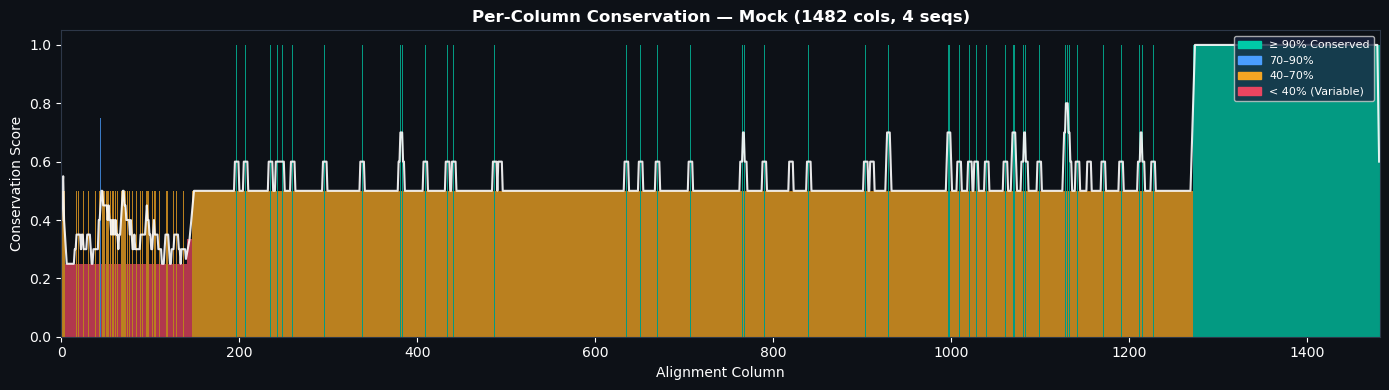

00:16:31 [INFO] Figure saved → c:\Users\infom\Desktop\bioinfo\ass1\results\figures\msa_heatmap_mock.png


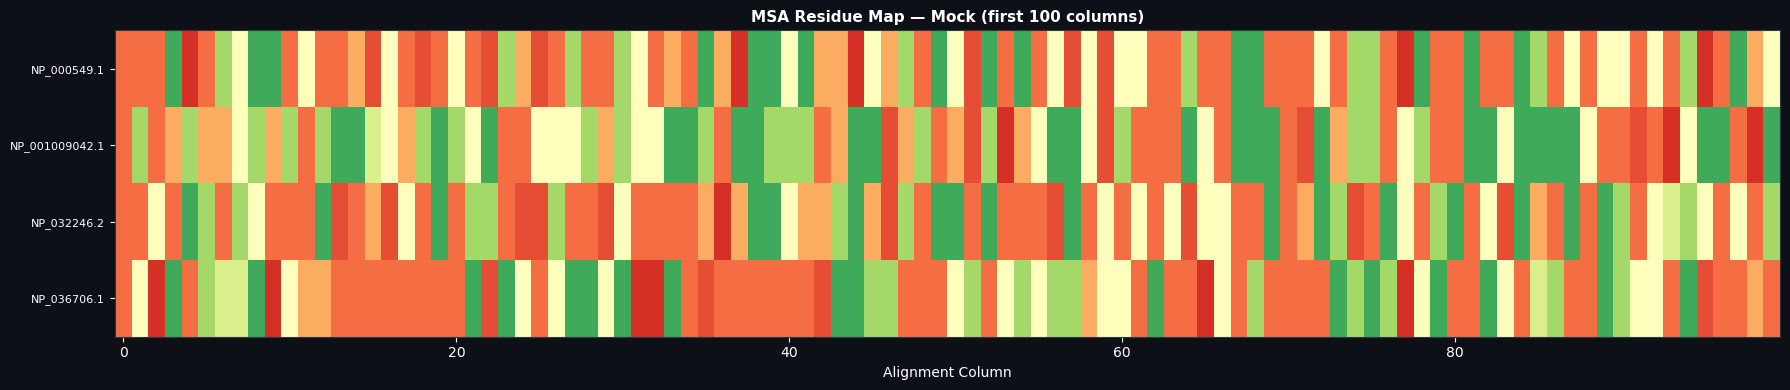

00:16:31 [INFO] Alignment saved (1 record(s)) → c:\Users\infom\Desktop\bioinfo\ass1\results\alignments\mock_alignment.fasta



✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
  MSA module complete.
  Input written to:    c:\Users\infom\Desktop\bioinfo\ass1\data\processed
  Alignments saved to: c:\Users\infom\Desktop\bioinfo\ass1\results\alignments
  Figures saved to:    c:\Users\infom\Desktop\bioinfo\ass1\results\figures
  Metrics saved to:    c:\Users\infom\Desktop\bioinfo\ass1\results\metrics
══════════════════════════════════════════════════════════════════════


In [11]:
# =============================================================
# MAIN — Demo run with Config-Integrated I/O
# =============================================================
from src.utils import load_fasta
if __name__ == "__main__":
    print("\n" + "═" * 70)
    print("  DCIT 411 — Multiple Sequence Alignment Module (Config-Integrated)")
    print("  Student: Amoako Albert | ID: 11227686")
    print("═" * 70)
    
    # ── Load cleaned sequences from configured directory ───────
    try:
        records = load_fasta(os.path.join(config.PROCESSED_DATA_DIR, "hemoglobin_clean.fasta"))
        _log(f"Successfully loaded {len(records)} sequences for MSA")
    except FileNotFoundError:
        _log("Cleaned file not found. Using fallback demo sequences.", "warning")
        # Fallback demo sequences
        demo_seqs = {
            "HBA_Human": "MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHS",
            "HBA_Mouse": "MVLSGEDKSNIKAAWGKIGGHGAEYGAEALERMFASFPTTKTYFPHFDVSHGSAQVKAHGKKVAEALTNAVGHS",
            "HBA_Chicken": "MVLSAADKNNVKGIFTKIAGHAEEYGAETLERMFTTYPPTKTYFPHFDLSHGSAQIKAHGKKVVAALIEAANHA",
            "HBA_Fish": "MSLSDKDKAAVRALWSKVNPHDIGAEALGRLLVVYPWTQRYFDSFGDLSSASAIMGNAKVKAHGKKVIDGLVGR",
            "HBA_Dog": "MVLSAADKGNVKAAWGKVGGHAAEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKAHGKKVGDALTNAVASH",
        }
        records = [SeqRecord(Seq(seq), id=sid, description="") for sid, seq in demo_seqs.items()]
    
    # ── Step 1: Check tools ───────────────────────────────────
    print("\n[1] Checking external tool availability...")
    tool_status = check_all_tools()
    
    # ── Step 2: Write input FASTA to configured directory ─────
    input_filename = "msa_input_demo.fasta"
    input_path = write_multifasta(records, filename=input_filename)
    
    # ── Step 3: Run whichever tools are available ─────────────
    alignments = {}
    for tool, available in tool_status.items():
        if tool == "clustalw2" and available:
            print("\n[2a] Running ClustalW...")
            try:
                alignments["ClustalW"] = run_clustalw(input_path)
            except Exception as e:
                _log(f"ClustalW failed: {e}", "error")
        elif tool == "mafft" and available:
            print("\n[2b] Running MAFFT...")
            try:
                alignments["MAFFT"] = run_mafft(input_path)
            except Exception as e:
                _log(f"MAFFT failed: {e}", "error")
        elif tool == "muscle" and available:
            print("\n[2c] Running MUSCLE...")
            try:
                alignments["MUSCLE"] = run_muscle(input_path)
            except Exception as e:
                _log(f"MUSCLE failed: {e}", "error")
    
    if not alignments:
        print("\n  No external MSA tools found. Creating mock alignment for demo.")
        max_len = max(len(r.seq) for r in records)
        padded = [SeqRecord(Seq(str(r.seq).ljust(max_len, "-")), id=r.id, description="") for r in records]
        alignments["Mock"] = MultipleSeqAlignment(padded)
    
    # ── Step 4: Print summaries ───────────────────────────────
    for tool_name, aln in alignments.items():
        print_msa_summary(aln, label=tool_name)
        print_alignment_block(aln, start=0, end=50, label=tool_name)
    
    # ── Step 5: Consensus sequences ──────────────────────────
    print("\n[3] Generating consensus sequences...")
    first_aln = list(alignments.values())[0]
    consensus_records = compare_consensus_thresholds(first_aln)
    save_consensus(consensus_records, filename="consensus_demo.fasta")
    
    # ── Step 6: Benchmark (if multiple tools available) ───────
    if len(alignments) >= 2:
        print("\n[4] Running benchmark comparison...")
        benchmark_results = benchmark_all(records, input_filename="msa_benchmark_input.fasta")
        save_benchmark_csv(benchmark_results)
        plot_benchmark_comparison(benchmark_results, filename="benchmark_comparison.png")
    
    # ── Step 7: Visualizations ────────────────────────────────
    print("\n[5] Generating figures...")
    for tool_name, aln in alignments.items():
        plot_conservation_track(aln, tool_name=tool_name, filename=f"conservation_{tool_name.lower()}.png")
        plot_msa_heatmap(aln, tool_name=tool_name, filename=f"msa_heatmap_{tool_name.lower()}.png")
        save_alignment(aln, filename=f"{tool_name.lower()}_alignment.fasta")
    
    # ── Summary ───────────────────────────────────────────────
    print("\n" + "✓" * 40)
    print("  MSA module complete.")
    print(f"  Input written to:    {config.PROCESSED_DATA_DIR}")
    print(f"  Alignments saved to: {config.ALIGNMENTS_DIR}")
    print(f"  Figures saved to:    {config.FIGURES_DIR}")
    print(f"  Metrics saved to:    {config.METRICS_DIR}")
    print("═" * 70)